# 0. 课程前言

此为《人工智能安全》实验课第三部分：可认证鲁棒性实验部分.


回顾对抗攻击实验部分，其核心目标是寻找使模型分类失效的最小对抗扰动。具体而言，对抗攻击可形式化为如下优化问题：

$$
\delta^* = \arg \max _{||\delta|| \le \epsilon} \mathcal L (h_\theta(x), y)
$$


其中，扰动 $\delta$ 的优化解域存在显著差异性：部分解会导致模型以高概率误判（对抗攻击上界），而另一部分解仅能引发低概率误判（对抗攻击下界）。这种优化目标的上下界分析构成了对抗攻防研究的核心框架。

基于这个优化问题，我们在对抗攻击部分介绍了 **FGSM(快速梯度符号法)** 和 **PGD(投影梯度下降法)**, 让我们借助 PGD ，对这类攻击算法进行回顾。


# 1. 训练准备

我们先引入三个简单的神经网络模型：

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [8]:
model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

/tmp/ipykernel_413254/811293303.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
/tmp/ipykernel_413254/811293303

<All keys matched successfully>

PGD 对抗样本生成算法借助以下目标优化函数：

$$
\begin{align}
Rep&eat: \notag \\
&\delta := \mathcal P (\delta + \alpha \nabla _\delta \mathcal L (h_\theta(x+\delta), y)) \notag 
\end{align}
$$

In [9]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

测试 PGD 在 CNN 模型上的效果：

In [12]:
mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

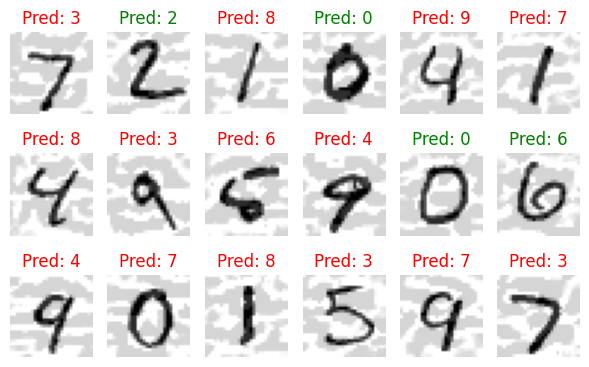

In [16]:
delta = pgd(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

PGD 算法在三种模型上的攻击效果：

In [14]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [18]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd, 0.1, 1e-2, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd, 0.1, 1e-2, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd, 0.1, 1e-2, 40)[0])

2-layer DNN: 0.9557


4-layer DNN: 0.9907
CNN: 0.7325


# 有目标的 PGD 攻击算法

我们目前探讨的 PGD 算法属于无目标攻击算法，这意味着，该攻击算法旨在将标签变更为任意其他标签，并非变更至某个特定的目标标签。

我们能够调整攻击策略，将其转换为 “有目标攻击” 任务。在此情形下，不但需要最大化真实标签的损失，还得最小化目标标签的损失。

$$
\delta^* = \arg \min_{||\delta||\le \epsilon} \left( \mathcal{L}(h_\theta(x+\delta), y) - \mathcal{L} (h_\theta(x+\delta), y_{targ}) \right)
$$

In [22]:
def pgd_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

测试有目标攻击的 PGD 算法在 CNN 上的表现：

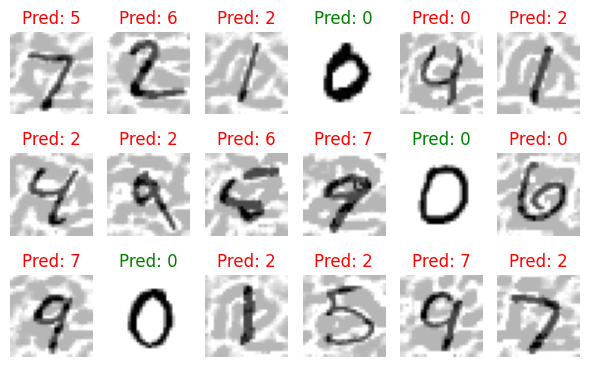

In [23]:
delta = pgd_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

值得注意的是，在有些情况下我们实际上并未达到目标类别。这是因为，我们只考虑了真实类别与目标类别的对数几率，而不关心其他类别会发生什么（实际上，有可能在最大化的目标类别的对数几率小于某个其他类别的对数几率）。

我们可以修改目标函数，最大化目标类别对数几率并最小化其他所有类别的对数几率。

$$
\delta^* = \arg \max_{\|\delta\| \leq \epsilon} \left ( h_\theta(x + \delta, {y_{\mathrm{targ}}}) - \sum_{y' \neq y_{\mathrm{targ}}} h_\theta(x + \delta, {y'}) \right )
$$

In [24]:
def pgd_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

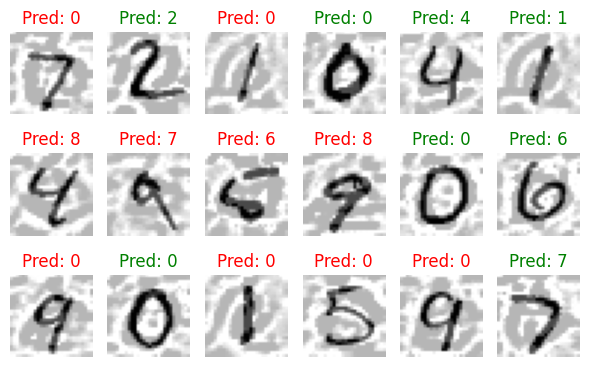

In [25]:
delta = pgd_targ2(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

在前面的实验中，我们使用 PGD 和有目标的 PGD 攻击算法对模型进行了攻击实验，这些攻击方法能够有效地找到模型的脆弱点，使模型在面对微小扰动时做出错误的预测。然而，这些攻击方法只能展示模型在某些特定扰动下的不鲁棒性，而无法提供关于模型鲁棒性的全局信息。

在实际应用中，我们不仅需要知道模型在某些特定攻击下的表现，更需要了解模型在一定扰动范围内的鲁棒性，确保模型在面对各种可能的扰动时都能做出正确的预测。

可认证鲁棒性，即在面对对抗样本的时候，找到一个可以量化的界限，即明确一个标准，以判断系统在面对恶意干扰或异常状况时的表现程度，这个可量化的界限可以帮助研究者评估模型的鲁棒程度，并采取相应的改进措施。


我们将对抗攻击方法系统性地划分为三类研究范式：
1. **启发式局部优化**

    找到优化目标 $\delta$ 的下界，即"通过启发式算法找到一个对抗样本"。主流方法如 **FGSM(快速梯度符号法)** 和 **PGD(投影梯度下降法)** 等，通过经验驱动的局部搜索策略构造对抗样本。这类方法本质上是对非凸优化问题的近似求解，虽能有效发现对抗样本，但无法保证获得全局最优解，属于对抗攻击下界的探索。
2. **精确全局优化**

    针对特定网络结构（如分段线性激活函数），将对抗样本构造问题转化为组合优化问题，利用混合整数规划（MIP）等数学工具进行精确求解。该方法能够确定性地验证是否存在导致误判的对抗样本，但受限于计算复杂度，主要适用于小型网络验证。
3. **可认证鲁棒性分析**

    通过构建网络结构的凸松弛模型（如线性规划松弛、半正定规划松弛），在更易处理的优化空间内推导对抗攻击上界。当松弛模型在给定扰动范围内无法构造成功攻击时，即可严格证明原始网络具有可认证鲁棒性。这种基于数学证明的方法为模型安全性提供了理论保证。


# 使用整数规划问题描述对抗攻击

对于一个神经网络，可以采用如下方式进行定义：
$$
\begin{align}
z_1 &= x \notag \\
z_{i+1} &= f_i(W_i z_i + b_i), i = 1, 2, \cdots, d \notag \\
h_\theta(x) &= z_{d+1} \notag
\end{align}
$$
通过上述递推关系，描述了神经网络从输入 $x$ 开始，历经一系列由权重矩阵 $W_i$、偏置向量 $b_i$ 以及激活函数 $f_i$ 共同作用的计算过程，最终输出 $h_\theta(x)$ 作为网络对输入 $x$ 的处理结果。

首先考虑如何将有针对性的对抗性攻击构建为一个优化问题。有针对性的攻击将尝试最小化真实类别 $h_\theta(x+\delta, y)$ 的对数几率，并最大化目标类别 $h_\theta(x+\delta, y_{targ})$ 的对数几率；

以 ReLu 作为网络激活函数，我们可以将目标写成如下带有约束的优化问题：

$$
\begin{align}
\arg \min _{z_1, z_2, \cdots, z_{d+1}} \; &(e_y - e_{y_{targ}})^T z_{d+1} \notag \\
subject \; \; to \; &||z_1 - x||_\infty \le \epsilon \notag \\
&z_{i+1} = max \{0, W_i z_i + b_i\}, i = 1, 2, \cdots, d-1 \notag \\
&z_{d+1} = W_d z_d + b_d \notag
\end{align}
$$

这里的 $e_i$ 表示单位基，即一个在第 $i$ 个位置为 1，其他位置为 0 的向量。

我们去掉了显式的 $\delta$ 项，采用了一个对 $z_1$ （即第一层的对抗样本输入）在原始输入 $x$ 的 $\epsilon$ 范围内的约束。

这里的优化问题的表述并不是求解器实际能解决的形式，因为涉及到最大运算符的等式约束，它既不是凸约束，也不是大多数优化求解器原生处理的约束。

为了能将其表述为能被求解器解决的问题，我们需要将其转化为另一种形式：二进制混合整数线性规划（MILP）。
> 二进制 MILP 是一个优化问题，由线性目标、线性等式和不等式约束以及对一些变量 $z_i \in \{0, 1\}$的二进制约束组成。一般来说，MILP是 NP 难题，所以不期望将其扩展到现代神经网络规模，但对于小问题，MILP是一个广泛研究的领域，并且存在比简单地尝试所有二进制变量设置的朴素暴力方法更具可扩展性的方法。

假设有 $z_{i+1} = max\{0, W_i z_i + b_i\}$ 可能取值的一些已知上下界（由 $l_i$ 和 $u_i$ 表示），我们引入一组与 $z_{i+1}$ 形状相同的二进制变量 $v_i$ ，我们可用以下不等式来等价于约束条件 $z_{i+1} = max\{0, W_i z_i + b_i\}$：

$$
\begin{align}
z_{i+1} &\ge W_i z_i + b_i \notag \\
z_{i+1} &\ge 0 \notag \\
u_i \cdot v_i &\ge z_{i+1} \notag \\
W_i z_i + b_i &\ge z_{i+1} + (1 - v_i) l_i \notag \\
v_i &\in \{0, 1\}^{|v_i|} \notag
\end{align}
$$

此时的问题就变成了求解 $l_i$ 和 $u_i$ ，受求解器的求解时间限制，不能简单地令其为 $-10^100$ 和 $10^100$ 这样显然存在的解。但我们实际上可以用与计算有目标攻击完全相同的方式精确计算这些界的值：通过最小化中间层的单个神经元的激活值来计算上界或下界。

$$
\begin{align}
\arg \min_{z_1, z_2, \cdots, z_{k+1}} &e_j^T z_{k+1} \notag \\
subject \; \; to \; &||z_1 - x||_\infty \le \epsilon \notag \\
&z_{i+1} = max\{0, W_i z_i + b_i\}, i = 1, 2, \cdots, k-1 \notag \\
&z_{k+1} = W_k z_k + b_k \notag
\end{align}
$$

虽然上述公式能求解上下界的精确解，但这样我们实际上是在为网络中的每个隐藏单元求解两个整数规划问题，所以这是极其不切实际的。
更实际的做法是简单地选取一组更加宽松（但又不如同 $10^{100}$ 那样完全“空洞”）且计算速度更快的边界。

一个自然的选择是使用简单的区间边界，对于某一层而言，前一层的输出 $x$ 存在一些边界 $\tilde l \le x \le \tilde u$，那么，这一层的 $z$ 存在的上下界即为使得 $z = Wx + b$ 的最大或最小值。

考虑 $z$ 所在层的第 $i$ 个神经元，有

$$
(Wz + b)_i = \sum_j w_{ij}x_j + b_i
$$

显然，求这一层的下界，需采用如下策略：当 $W_{ij}$ 为负时，应该选取 $x_j = \tilde u_j$ 这个上界；当 $W_{ij}$ 为正时，应该选取 $x_j = \tilde l_j$ 这个下界。（若求层的上界，则反之亦然）。因此，我们得到了 $z = Wx + b$ 的边界集合，有以下条件给出：

$$
max\{W, 0\} \tilde l + min \{W, 0\} \tilde u + b \le (Wx + b) \le max\{W, 0\}\tilde u + min \{W, 0\} \tilde l + b
$$

需要注意的是，这个上下界并不是精确的，而是一组更宽松的界限。

下面，我们在神经网络模型上计算每一层的区间边界：

In [26]:
def bound_propagation(model, initial_bound):
    # 传入参数：initial_bound 为初始输入的扰动区间，即 [x - epsilon, x + epsilon]
    l, u = initial_bound
    bounds = []
    
    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t() 
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t() 
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])
            
            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) + 
                  layer.bias[None,:,None,None])
            
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)
            
        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds

接下来，我们输出模型最后一层在第一个样本("0"图像)上的上下界信息：

In [27]:
epsilon = 0.1
bounds = bound_propagation(model_cnn, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
# print: 模型最后一层的第一个样本的下界信息
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-2855.4631 -2571.039  -3696.8293 -2543.9111 -2867.7935 -2444.5105
 -2912.023  -2475.7058 -2545.2742 -2578.3105]
upper bound:  [2186.5938 2673.1711 2457.4033 2726.826  2844.7742 3080.524  2242.0413
 3211.849  3151.519  2782.5747]


In [28]:
epsilon = 0.1
bounds = bound_propagation(model_dnn_2, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-20.560423 -23.64547  -17.535437 -16.681828 -32.128284 -22.724869
 -30.491901 -15.737773 -23.58483  -25.076939]
upper bound:  [19.24827  14.374581 25.719341 29.486425 18.704813 28.60849  11.866371
 32.1335   23.711868 25.589342]


In [29]:
epsilon = 0.1
bounds = bound_propagation(model_dnn_4, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-220.44913 -206.34962 -187.77368 -221.78787 -233.58583 -179.13441
 -244.60938 -202.73329 -207.64474 -204.78436]
upper bound:  [192.9366  211.39684 180.75684 212.42493 194.95622 216.43507 192.93724
 239.62477 209.22014 220.56755]


# 在整数规划中使用这些界限

上述的整数规划问题已经解决了上下界的范围问题，现在，我们使用求解器来求解这个整数规划问题。

我们把上述所有整数规划约束结合起来，指定了如下最终的整数规划公式：

$$
\begin{align}
\arg \min _{z_1, z_2, \cdots, z_{d+1}, v_1, v_2, v_{d-1}} &{e_y - e_{y_{targ}}}^T z_{d+1} \notag \\
subject \; \; to \;  &z_{i+1} \ge W_i z_i + b_i, i = 1, 2, \cdots, d-1 \notag \\
&z_{i+1} \ge 0, i = 1, 2, \cdots, d-1 \notag \\
&u_i \cdot v_i \ge z_{i+1}, i = 1, 2, \cdots, d-1 \notag \\
&W_i z_i + b_i \ge z_{i+1} + (1 - v_1) l_i, i=1, 2, \cdots, d-1 \notag \\
&v_i \in \{0, 1\}^{|v_i|} , i = 1, 2, \cdots, d-1 \notag \\
&z_1 \le x + \delta \notag \\
&z_1 \ge x - \delta  \notag \\
&z_{d+1} = W_d z_d + b_d \notag
\end{align}
$$

本实验中，我们使用 cvxpy 库中的 Gurobi 求解器来求解这个整数规划。

In [30]:
import cvxpy as cp

# 定义线性约束
def form_milp(model, c, initial_bounds, bounds):
    linear_layers = [(layer, bound) for layer, bound in zip(model,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1
    
    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] + 
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features, boolean=True) for layer, _ in linear_layers[:-1]]
    
    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bounds[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bounds[1][0].view(-1).detach().cpu().numpy()
    
    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i], 
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i])]
    
    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]
    
    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]
    
    return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)

考虑到求解时间，我们选择一个小规模的神经网络作为求解对象。

本例中，我们将第一个图像 y[0] 作为攻击图像，其真实标签为 7 ，目标标签为 2 。

In [32]:
model_small = nn.Sequential(Flatten(), nn.Linear(784,50), nn.ReLU(), 
                            nn.Linear(50,20), nn.ReLU(), 
                            nn.Linear(20,10)).to(device)

# load model from disk
model_small.load_state_dict(torch.load("model_small.pt"))

/tmp/ipykernel_413254/4266730246.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_small.load_state_dict(torch.load("model_small.pt"))


<All keys matched successfully>

In [33]:
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

# 基向量，定义原始对象和目标对象
# y[0]的真实标签为 7 ，目标标签为 2
c = np.zeros(10)
c[y[0].item()] = 1
c[2] = -1

prob, (z, v) = form_milp(model_small, c, initial_bound, bounds)

In [34]:
prob.solve(solver=cp.GUROBI, verbose=True)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Apr 14 10:39:22 AM: Your problem has 934 variables, 1858 constraints, and 0 parameters.
(CVXPY) Apr 14 10:39:22 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 14 10:39:22 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 14 10:39:22 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 14 10:39:22 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 14 10:39:22 AM: Compiling problem (target solver=GUROBI)

-3.225911939123418

求解器得到的目标是负的，这意味着我们能够找到一种扰动，使得目标类的类别的对数概率比原始类的类别的对数概率更大，即我们能够构造一个目标类别为 "2" 的对抗样本。

# 可认证鲁棒性

前面提到的基于整数规划优化问题的攻击方法，同时也给了我们验证鲁棒性的思路：对于一个给定的样本示例，我们想要知道其是否存在任何对抗样本，我们可以针对每个可能的目标类别，使用基于整数规划优化问题的攻击方法。如果这些目标类别中的任何一个有负数解，那么就存在一个目标类别的对抗样本。反之，如果对于任意目标类别，所有目标类别都不存在负数解，那么神经网络模型在这个示例上就被证明是鲁棒的。

举一个例子：对于手写数字图像识别这样的 10 分类任务，对于一张 “2” 类别的图像，我们对其使用基于整数规划的方法，以其他 9 类分别作为目标类别运行 9 次，若 “1” 类别作为目标类别存在负数解，则存在以 “1” 为目标类别的对抗样本。

让我们看看如何做到这一点，以验证较小的扰动球不能改变类别标签。

In [35]:
epsilon = 0.05
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_milp(model_small, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

Targeted attack 0 objective: 8.084621471168452
Targeted attack 1 objective: 12.975467614889116
Targeted attack 2 objective: 3.16368559925143
Targeted attack 3 objective: 2.4411197523280723
Targeted attack 4 objective: 11.65788101861424
Targeted attack 5 objective: 9.064827362176294
Targeted attack 6 objective: 22.402332700312176
Targeted attack 8 objective: 4.976967701637535
Targeted attack 9 objective: 6.069808212270474


其他 9 个类别的求解都为正数，这就说明不存在半径大小为 $\epsilon = 0.05$ 的 $\ell_\infty$ 对抗扰动。

In [36]:
epsilon = 0.1
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_milp(model_small, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

Targeted attack 0 objective: 0.774900466111629
Targeted attack 1 objective: 6.26327381581288
Targeted attack 2 objective: -3.225911939123418
Targeted attack 3 objective: -4.818509852618486
Targeted attack 4 objective: 5.186564397880513
Targeted attack 5 objective: 1.9734883186947645
Targeted attack 6 objective: 13.013704428222562
Targeted attack 8 objective: -2.256757870740434
Targeted attack 9 objective: 0.1290756386361407


在以 $\epsilon = 0.1$ 为半径的扰动球中，存在以 “2”，“3”，“8” 为目标样本的对抗性样本。

# 基于凸松弛求解目标函数上界

一个很显然的问题是，基于整数规划的内部最大化问题的精确解虽然很有研究价值，但是这种方法无法扩展到更大的网络，无论有多少计算资源，即使对中等规模的网络都很容易找到永远不会优化完成的问题。

因此上述的可验证鲁棒性并不够实用，我们需要快速获得内部最大化问题的上界，以此提供鲁棒性的正式保证。

例如，如果我们能获得一个上界，该上界仍然表明没有有针对性的攻击可以改变类别标签，这也提供了一种验证，即不可能有对抗样本。

在本节中，我们将介绍两种不同的形成上界的方法，一种是基于整数规划问题的凸松弛（提供一个更紧的界，但计算成本仍然较高），另一种基于界传播（提供了一个较松的界，但计算速度要快许多）。

## 基于整数规划问题的凸松弛

上述的整数规划问题求精确解的方法，计算成本主要高在引入的二进制约束 $v_i \in \{0, 1\}^{|v_i|}$, 用于精确捕获 ReLu 运算符。

如果去掉这个约束，即可从混合整数线性规划问题变为线性规划问题，从而快速求解。

因此，考虑对此二进制约束进行松弛处理，将元素取值从 $\{0, 1\}$ 放宽到 $[0, 1]$, 即可以取中间分数值。

除此之外，其他约束条件保持不变，这被称为整数问题的凸松弛。

对于松弛版本的优化攻击，如果求解的值仍然是正的，那么不存在对抗攻击，这是因为松弛集合严格大于原始集合，所以如果在松弛集合中不存在对抗样本，则原始集合也一定不存在。

我们可以使用如下方法来简单地描述这种松弛，对于原始的 ReLu 约束，它的所有取值是有界的，即在如下图中的向量取值中：

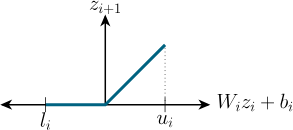

而当我们将 $v_i$ 松弛为分数值时，结果证明这相当于将这个有界 ReLu 集合松弛为它的凸包：

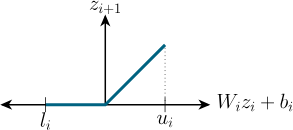

In [49]:
def form_lp(model, c, initial_bounds, bounds):
    linear_layers = [(layer, bound) for layer, bound in zip(model,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1
    
    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] + 
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features) for layer, _ in linear_layers[:-1]]
    
    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bound[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bound[1][0].view(-1).detach().cpu().numpy()
    
    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i], 
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i]),
                        v[i] >= 0,
                        v[i] <= 1]
    
    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]
    
    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]
    
    return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)

In [51]:
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)
c = np.eye(10)[y[0].item()] - np.eye(10)[2]

prob, (z, v) = form_lp(model_small, c, initial_bound, bounds)
print("Objective value:", prob.solve(solver=cp.GUROBI))
print("Last layer from relaxation:", z[3].value)

Objective value: -30.445467280811798
Last layer from relaxation: [ 10.61930755  -8.00783511  24.99608703   7.27186848 -14.09313748
   0.36844093   0.42339702  -5.44938025   6.15953599 -12.38435955]


In [53]:
print("Last layer from model:", 
      model_small(torch.tensor(z[0].value).float().view(1,1,28,28).to(device))[0].detach().cpu().numpy())

Last layer from model: [ 1.7471993  -2.5636814   8.261734    6.485653   -7.659953   -0.41698933
 -9.980528    6.367086    4.2566605  -2.2540815 ]


In [60]:
epsilon = 0.02
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_lp(model_small, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

Targeted attack 0 objective: 9.18712567594846
Targeted attack 1 objective: 14.61376613199486
Targeted attack 2 objective: 4.746316607451355
Targeted attack 3 objective: 3.8486686291440293
Targeted attack 4 objective: 14.239985579120846
Targeted attack 5 objective: 9.830999959024231
Targeted attack 6 objective: 23.256838783453667
Targeted attack 8 objective: 7.258987973138355
Targeted attack 9 objective: 7.865875866040316


In [63]:
epsilon = 0.01
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_dnn_4, initial_bound)

for y_targ in range(10):
    if y_targ != y[0].item():
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]
        prob, _ = form_lp(model_dnn_4, c, initial_bound, bounds)
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.ECOS)))

Targeted attack 0 objective: 4.9517729787365194
Targeted attack 1 objective: 3.874218213776362
Targeted attack 2 objective: 1.6757972500063651
Targeted attack 3 objective: -2.2969073548126184
Targeted attack 4 objective: 12.951596991011728
Targeted attack 5 objective: 0.140134351077827
Targeted attack 6 objective: 13.050637176316002
Targeted attack 8 objective: -1.4000302652154044
Targeted attack 9 objective: -2.093556869235737


## 凸松弛的更快解法

In [64]:
def interval_based_bound(model, c, bounds):
    # requires last layer to be linear
    cW = c.t() @ model[-1].weight
    cb = c.t() @ model[-1].bias
    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l.t() + cW.clamp(max=0) @ u.t() + cb[:,None]).t()  

In [65]:
epsilon = 0.02
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))
bounds = bound_propagation(model_small, initial_bound)
C = -torch.eye(10).to(device)
C[y[0].item(),:] += 1

print(interval_based_bound(model_small, C, bounds).detach().cpu().numpy())

[[-5.2146845  0.9834416 -8.95515   -9.430425  -1.6530738 -5.675324
   6.744165   0.        -9.852957  -7.0858884]]
